## Artificial Intelligence in Decision Making and Control of Industrial Applications [2023-24]
Assignment 1: Reinforcement Learning
Author: Matteo Mascheroni


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import seaborn as sns

In [39]:
class MultiAgentThreeDGridEnv:
    def __init__(self, shape=(10, 10, 10), starts=[(0, 0, 0), (0, 0, 9)], destinations=[(9, 9, 9), (9, 9, 0)], n_obstacles=15, stay_penalty=-15, collision_penalty=-10, goal_reward=100, step_penalty=-1):
        self.shape = shape
        self.starts = starts
        self.destinations = destinations
        self.n_obstacles = n_obstacles
        self.stay_penalty = stay_penalty
        self.collision_penalty = collision_penalty
        self.goal_reward = goal_reward
        self.step_penalty = step_penalty
        self.alpha = 1
        self.obstacles = self._generate_obstacles()
        self.agent_positions = list(starts)
        # initialise Q matrixes
        self.Q = [np.zeros((1000,7)),np.zeros((1000,7))]

        assert not (set(starts) & self.obstacles), "Start positions must not be in obstacles"
        assert not (set(destinations) & self.obstacles), "Destination positions must not be in obstacles"
        assert not(len(set([(0,0,1),(0,1,0),(1,0,0)])& self.obstacles)==3), "Agent 0 is blocked"
        assert not(len(set([(0,0,8),(0,1,9),(1,0,9)])& self.obstacles)==3), "Agent 1 is blocked"
        assert not(len(set([(9,9,8),(8,9,9),(9,8,9)])& self.obstacles)==3), "Destination 0 is blocked"
        assert not(len(set([(9,9,1),(8,9,0),(9,8,0)])& self.obstacles)==3), "Destination 0 is blocked"

    def _generate_obstacles(self):
        obstacles = set()

        while len(obstacles) < self.n_obstacles:
            obstacle = tuple(np.random.randint(0, s) for s in self.shape)
            if obstacle not in self.starts and obstacle not in self.destinations:
                obstacles.add(obstacle)
        return obstacles

    def reset(self):
        self.agent_positions = list(self.starts)
        self.obstacles = self._generate_obstacles()
        return [self._get_state(i) for i in range(len(self.starts))]

    def restart(self):
        self.agent_positions = list(self.starts)
        return [self._get_state(i) for i in range(len(self.starts))]

    def reset_q(self):
        self.Q = [np.zeros((1000,7)),np.zeros((1000,7))]

    def set_alpha(self, alpha):
        self.alpha = alpha


    def select_action(self, epsilon=1):
        actions = []
        move = [(0, 0, 0), (0, 0, 1), (0, 0, -1), (0, -1, 0), (0, 1, 0), (1, 0, 0), (-1, 0, 0)]
        # epsilon is the probability of choosing a random action
        if np.random.binomial(1, epsilon):
             actions = [np.random.randint(len(move)), np.random.randint(len(move))]
        # perform the best action
        else:
            prev_state = [self._get_state_single(0), self._get_state_single(1)]
            for i, state in enumerate(prev_state):
                actions.append(np.argmax(self.Q[i][np.where(state.flatten() == i+1)]))
        return actions


    def step(self, actions):
        new_positions = []
        rewards = []
        dones = []

        for i, action in enumerate(actions):
            move = [(0, 0, 0), (0, 0, 1), (0, 0, -1), (0, -1, 0), (0, 1, 0), (1, 0, 0), (-1, 0, 0)]
            # added that if the agent is in the destination it will wait there and take no reward
            if self.agent_positions[i] == self.destinations[i]:
               # print(f"Agent {i} is arrived")
                dones.append(True)
                rewards.append(0)
                new_positions.append(self.destinations[i])
            else:
                new_position = tuple(np.add(self.agent_positions[i], move[action]))
                if new_position == self.agent_positions[i]:
                    reward = self.stay_penalty
                elif (0 <= new_position[0] < self.shape[0] and
                      0 <= new_position[1] < self.shape[1] and
                      0 <= new_position[2] < self.shape[2] and
                      new_position not in self.obstacles and
                      new_positions.count(new_position) != 2):
                    # given the check on the conditions the two agents could collide only if they move in the same cell
                    self.agent_positions[i] = new_position
                    reward = self.goal_reward if new_position == self.destinations[i] else self.step_penalty
                else:
                    reward = self.collision_penalty
                    new_position = self.agent_positions[i]

                new_positions.append(new_position)
                rewards.append(reward)
                dones.append(new_position == self.destinations[i])

        states = [self._get_state_single(i) for i in range(len(self.starts))]
        return states, rewards, dones

    def episode(self, epsilon=1):
        self.agent_positions = list(self.starts)
        dones = [False * 2]
        steps = 0
        while dones.count(True) != 2:
            steps += 1
            actions = self.select_action(epsilon=epsilon)
            prev_state = [self._get_state_single(0), self._get_state_single(1)]
            new_state,rewards, done = self.step(actions=actions)
            dones = done
            # Q update
            for i,pos in enumerate([1,2]):
                x = np.where(prev_state[i].flatten() == pos)[0][0]
                y = actions[i]
                self.Q[i][x,y] = self.Q[i][x,y] + self.alpha * (rewards[i] + np.max(self.Q[i][np.where(new_state[i].flatten() == pos)]) - self.Q[i][x,y])
            # print(f"Number of steps: {steps}")
        return steps

    def value_episode(self, actions):
        self.agent_positions = list(self.starts)
        dones = [False * 2]
        reward_0 = []
        reward_1 = []
        if [10] in actions:
            #print(f"Return is: {-200} ")
            return [-100,-100]
        else:
            policy_0 = np.array(actions[0])
            policy_0.resize(max(len(actions[0]), len(actions[1])))
            policy_1 = np.array(actions[1])
            policy_1.resize(max(len(actions[0]), len(actions[1])))
            for i in range(len(policy_0)):
                actions = [policy_0[i], policy_1[i]]
                new_state,rewards, done = self.step(actions=actions)
                reward_0.append(rewards[0])
                reward_1.append(rewards[1])
                dones = done
            #print(f"Return is: {[sum(reward_0), sum(reward_1)]} ")
            return [sum(reward_0), sum(reward_1)]


    def _get_state(self, agent_index):
        state = np.zeros(self.shape)
        for obs in self.obstacles:
            state[obs] = -1
        state[self.destinations[agent_index]] = -2
        for i, pos in enumerate(self.agent_positions):
#            if state[pos] == 0:
            state[pos] = i + 1
        return state

    def _get_state_render(self):
        state = np.zeros(self.shape)
        for obs in self.obstacles:
            state[obs] = -1
        state[self.destinations[0]] = -2
        state[self.destinations[1]] = -3
        for i, pos in enumerate(self.agent_positions):
            state[pos] = i+1
        return state

    def _get_state_single(self, agent_index):
        state = np.zeros(self.shape)
        for obs in self.obstacles:
            state[obs] = -1
        state[self.destinations[agent_index]] = -2
        state[self.agent_positions[agent_index]] = agent_index + 1
        return state

    def _get_reward(self, agent_index, position):
        if position == self.destinations[agent_index]:
            return self.goal_reward
        return self.step_penalty

    def policy_state(self, agent_index, pos):
        state =  np.zeros(self.shape)
        state[pos] = agent_index + 1
        return state

    def _get_policy(self, agent_index):
        pos = self.starts[agent_index]
        move = [(0, 0, 0), (0, 0, 1), (0, 0, -1), (0, -1, 0), (0, 1, 0), (1, 0, 0), (-1, 0, 0)]
        done = False
        policy = []
        state =  self.policy_state(agent_index,pos)
        steps = 0
        while not done:
            if steps < 100 :
                s = np.where(state.flatten() == agent_index+1)
                best_action = np.argmax(self.Q[agent_index][s])
                policy.append(best_action)
                try:
                    pos = tuple(np.add(pos, move[best_action]))
                    done = pos == self.destinations[agent_index]
                    state = self.policy_state(agent_index, pos)
                    steps += 1
                except IndexError:
                    policy = [10]
                    return(policy)
            else:
                policy = [10]
                #print(f"The best policy for agent {agent_index}: {policy}")
                return(policy)
        #print(f"The best policy for agent {agent_index}: {policy}")
        return(policy)


    def render(self):
        self.ax.cla()  # Clear the axis to redraw
        grid = self._get_state_render()  # Get the grid state

        # Only fill spaces that are not empty
        filled = np.zeros(grid.shape, dtype=bool)
        filled[grid != 0] = True

        # Create a color mapping for the grid
        colors = np.empty(grid.shape, dtype=object)
        colors[grid == -1] = 'red'    # Obstacles in red
        colors[grid == 1] = 'green'   # Agent in green
        colors[grid == -2] = 'yellow' # Destination in yellow
        colors[grid == 2] = "blue"
        colors[grid == -3] = 'orange'

        # Plot the grid using voxels
        self.ax.voxels(filled, facecolors=colors, edgecolors='k')

        self.ax.set_xlabel('X axis')
        self.ax.set_ylabel('Y axis')
        self.ax.set_zlabel('Z axis')


    def animate_solution(self, policy):
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
      self.ax = ax

      # Prepare the animation function
      def update(num):
          action = policy[num]
          self.step(action)
          self.render()
          return self.ax,

      # Create the animation
      ani = animation.FuncAnimation(fig, update, frames=len(policy), blit=False, interval=500, repeat=False)
      plt.close(fig)  # Prevent duplicate display
      return ani
    """
    Further methods can be defined if necessary (e.g., random_state(), start_state(), animation, ...)
    """

## Pseudocode

The algorithm developed for the case is an independent Q-Learning algorithm. In this case two different Q matrix are define (one for each agent). So state space and actions are separated between the two agents and their interaction is modelled throught the reward logic, if the action selected would result into a collision penalty for both agents. This does not imply that the two agents cannot be in the same position at the same time, in fact if the first agent move to the previous position of the second agent and the second agent incurs in a collision the position of the two agent at the end of the step would coincide but the collision penalty would be attributed only to second agent.
 states for agent i: $ s_i \in S $
 Q matrix for agent i : $Q_i $
 action for agent i : $ a_i \in A_i$
 reward for agent i in time t : $ r_{i}^{t} $
 current step : $t$
 learning rate : $\alpha$

#### Initialization
For every agent i the Q matrix is set to 0: $Q_i(s_i,a_i) = 0$ for all $s_i \in S, a_i \in a_i$

#### For every episode
while both agents are not in their respective destinations:
    with probability $epsilon$: choose a random action $a_{i}^{t} \in A_i$
    otherwise: choose the action $a_{i}^{t} \in \arg \max_{a_i} Q_i(s_{i}^{t}, a_i)$
    (other agents will choose their actions)
    observe agent's rewards $r_{i}^{t}$ and the next state $s_{i}^{t+1}$
    upload the Q_matrix: $Q_i(s_{i}^{t}, a_i) \leftarrow Q_i(s_{i}^{t}, a_i) + \alpha [r_{i}^{t} + \max_{a_{i}^{'}}Q_i(s_{i}^{t+1}, a_i) - Q_i(s_{i}^{t}, a_i)]$

#### Observations
The presented algorithm consider a different state for every agent in which only its position was considered, this was done mainly to reduce the dimension (it increase linearly with the number of agents instead that exponentially). This choice could lead to a non-stationarity problem in the solution because the change is state given by the movement of other agents is not captured. Despite this the algorithm resulted effective in finding the best path avoiding collisions.

The collision detection in the step() function was not correct, therefore it was modified. The actual check for collision between two agents check if the next move of both agents would result in the same position (this condition still don't completely avoid the possibility of agents being in the same spot).

If during training one of the two agent reach the destination it will stay there waiting for the other agent to reach its destination (without collecting rewards or updating Q).

When generating obstacles now the class checks if agents and destinations are not surrounded by blocks, this would result is an agent not being able to leave its initial position or reaching its destination




In [40]:
def trainig(epsilon, alpha, iter, multi_agent):
    data = []
    multi_agent.set_alpha(alpha)
    steps = 0
    for i in range(iter):
        multi_agent.restart()
        steps += multi_agent.episode(epsilon=epsilon)
        multi_agent.restart()
        value = multi_agent.value_episode(actions=[multi_agent._get_policy(0),multi_agent._get_policy(1)])
        data.append(sum(value))
    print(f"Number of total steps: {steps}")
    return data

In [41]:
# create the object multiagent
multi_agent = MultiAgentThreeDGridEnv()

In [42]:
multi_agent.reset()

[array([[[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  

## Training
The following block perform the training of the model with different parameters. It shows the number of steps performed during training and plot the value function of the best policy with respect of different epsilon values.
Estimating the best policy in the first episodes of training is not always possible, sometimes selecting the action with the associated maximum Q value led to a loop, therefore a maximum steps was set to 100, if selecting the greedy policy resulted in 100 or more steps the total reward for the policy is set to -100.
The plot shows the total value (the sum of the value of the two agents) as the training episodes progress.

Number of total steps: 65559
Number of total steps: 86381
Number of total steps: 2861012


<Axes: xlabel='episode', ylabel='value'>

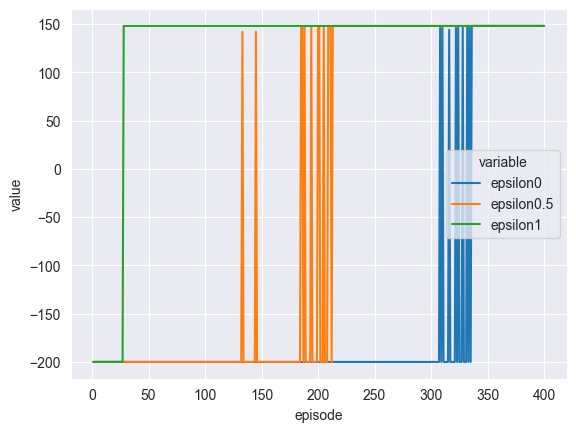

In [43]:
# running this block allows to visualize how different hyperparameter affect the training phase
data_collector = pd.DataFrame()
epsilon = [0,0.5,1] # list of different possible epsilon
alpha = 0.5 # alpha value
episodes = 400 # number of episode performed for each epsilon
for i in epsilon:
    col_name = "epsilon"+str(i)
    multi_agent.reset_q()
    data_collector[col_name]=trainig(i,alpha,episodes, multi_agent=multi_agent)
data_collector['episode'] = np.arange(1,data_collector.shape[0] + 1)
sns.lineplot(x='episode', y='value', hue='variable',
             data=pd.melt(data_collector, ['episode']))

## Results
It is possible to see that a smaller epsilon resulted in a less total steps needed for the training but with a later and less stable convergence of the value function.

In [53]:
# reset the agent
multi_agent.restart()
multi_agent.reset_q()

In [54]:
# train the agent
np.random.seed(42)
trainig(epsilon=1,alpha=0.9,iter=50, multi_agent=multi_agent)

Number of total steps: 314423


[-200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 -200,
 148,
 146,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148]

## Results of training
Setting the parameters as:
$\epsilon = 1$
$\alpha = 0.9$
$\text{number of iterations} = 50$
Resulted in a training time of $9.220 \text{ seconds}$


In [55]:
# after training it is possible to visualize the animation for the optimal policy
policy_0 = multi_agent._get_policy(0)
policy_1 = multi_agent._get_policy(1)
policy = [[policy_0[x],y] for x,y in enumerate(policy_1)]
print(len(policy))
multi_agent.restart()
ani = multi_agent.animate_solution(policy)


27


In [57]:
# Due to some trouble with Jupiter the file is saved in the same directory as the script as an mp4. file
ani.save("multi_agent_4.mp4")

In [59]:
from IPython.display import HTML
HTML(ani.to_html5_video())